In [7]:
# Install required packages
%pip install gymnasium numpy tensorflow matplotlib seaborn pydot graphviz pygame scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Imports
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import time
from BlockdokuEnv import BlockdokuEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Configuration parameters for the whole setup
gamma = patience = 0.99  # Discount factor for past rewards
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0
env = BlockdokuEnv(render_mode='pygame', flatten=False)
obs, info = env.reset()
print('Observation:', env.observation_space)
print('Action:     ', env.action_space)

Observation: Tuple(MultiBinary((9, 9)), MultiBinary((5, 5)), MultiBinary((5, 5)), MultiBinary((5, 5)))
Action:      Tuple(Discrete(3), Discrete(81))


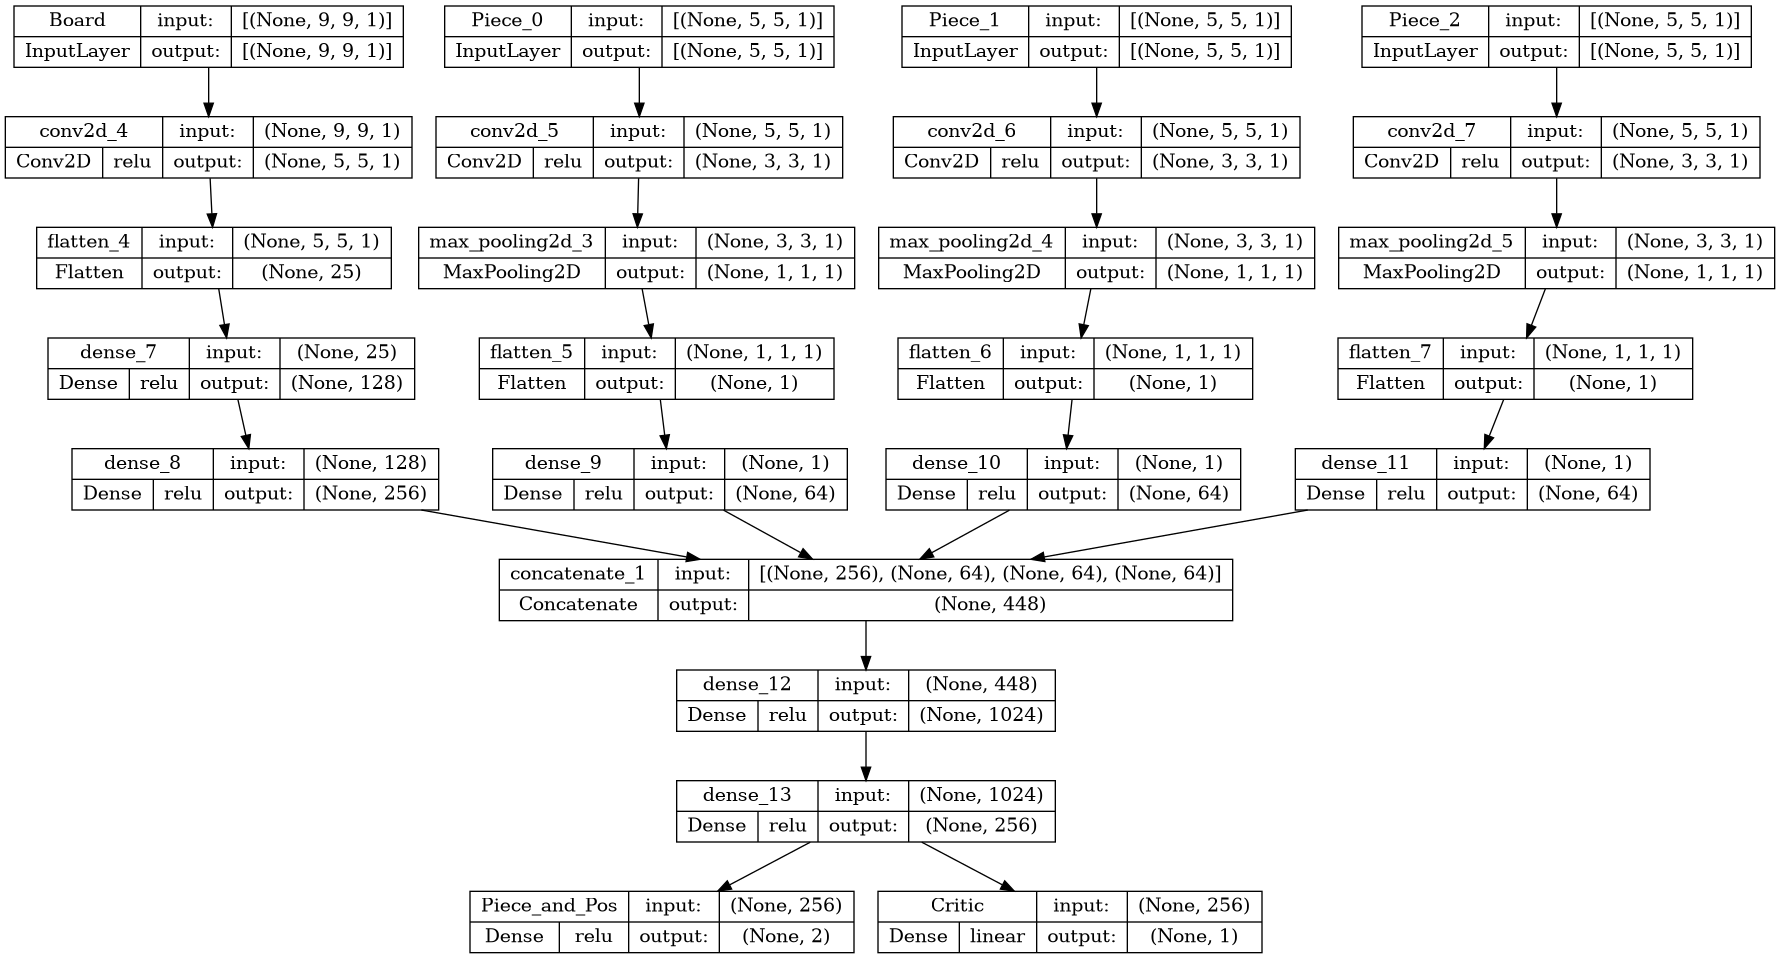

In [10]:
# Define the model
inputs = []
outputs = []
hiddenModels = []

boardInput = layers.Input((9,9,1), name='Board')
x = layers.Conv2D(1, 5, activation='relu', input_shape=(9,9,1))(boardInput)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
boardOutput = layers.Dense(256, activation='relu')(x)

inputs.append(boardInput)
hiddenModels.append(boardOutput)

for i in range(3):
    input = layers.Input((5,5,1), name=f'Piece_{i}')
    x = layers.Conv2D(1, 3, activation='relu', input_shape=(5,5,1))(input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    output = layers.Dense(64, activation='relu')(x)

    inputs.append(input)
    hiddenModels.append(output)

merged = layers.Concatenate(axis=1)(hiddenModels)
hidden = layers.Dense(1024, activation='relu')(merged)
penultimate = layers.Dense(256, activation='relu')(hidden)

# If we want to do probability outputs
# position = layers.Dense(81, activation='relu', name='Position_Probabilites')(penultimate)
# piece = layers.Dense(3, activation='relu', name='Piece_Probabilities')(penultimate)
# model = ks.Model(inputs=inputs, outputs=[position, piece, critic])

# If we want to do definite outputs
action = layers.Dense(2, activation='relu', name='Piece_and_Pos')(penultimate)
critic = layers.Dense(1, name='Critic')(penultimate)
model = ks.Model(inputs=inputs, outputs=[action, critic])

ks.utils.plot_model(model, show_layer_activations=True, show_shapes=True)

In [ ]:
# Main Training loop
optimizer = ks.optimizers.Adam(learning_rate=0.001)
huber_loss = ks.losses.Huber()
action_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

def formatObs(obs):
    return [tf.convert_to_tensor(np.expand_dims(o, 0)) for o in obs]

try:
    while True: # Run until solved
        # Get an initial state from resetting the enviorment
        episode_reward = 0
        prev_state, info = env.reset(seed=42)
        board, p1, p2, p3 = formatObs(prev_state)

        with tf.GradientTape() as tape:
            while True:
                env.render()
                time.sleep(.5)

                # Predict action probabilities and estimated future rewards from environment state
                action, critic_val = model([board, p1, p2, p3])
                action = action[0]
                piece, pos = action
                critic_value_history.append(critic_val[0,0])

                # If we want to do probability outputs
                # Sample action from action probability distribution
                # action = np.random.choice(np.arange(81), p=action_probs[1:])
                # Or just pick the biggest one
                # piece = piece_probs.tolist().index(piece_probs.max())

                # I suspect the log here, is to keep it within the same scale
                # But the example code works with or without it, so...
                action_history.append(action)
                action_history.append(tf.math.log(action))

                # Apply the sampled action in our environment
                env.print(f'Piece: {piece_probs}')
                env.print(f'Pos: {pos_probs.reshape((9,9))}')
                env.print(f'pos: {pos}')
                env.print(f'piece: {piece}')
                env.print(f'Action: {action}')

                state, reward, done, _, info = env.step(np.round(action).astype(int))
                board, p1, p2, p3 = formatObs(state)

                rewards_history.append(reward)
                episode_reward += reward

                if done:
                    break

            # Update running reward to check condition for solving
            # This is polyak averaging (I think)
            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

            # Calculate expected value from rewards
            # - At each timestep what was the total reward received after that timestep
            # - Rewards in the past are discounted by multiplying them with gamma
            # - These are the labels for our critic
            returns = []
            discounted_sum = 0
            for r in reversed(rewards_history):
                discounted_sum = r + patience * discounted_sum
                returns.insert(0, discounted_sum)

            # Normalize
            # This seems to be getting the error of each reward (what we got - average of what we got)
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + eps).tolist()

            # Calculating loss values to update our network
            actor_losses = []
            critic_losses = []
            # Don't forget that action here is a tensor of shape (2,)
            for action, critic_guess, true_reward in zip(action_history, critic_value_history, returns):
                # At this point in history, the critic estimated that we would get a
                # total reward = `value` in the future. We took an action with log probability
                # of `log_prob` and ended up recieving a total reward = `ret`.
                # The actor must be updated so that it predicts an action that leads to
                # high rewards (compared to critic's estimate) with high probability.
                diff = true_reward - critic_guess
                # actor_losses.append(-tf.math.log(action) * diff)  # actor loss
                actor_losses.append(-action * diff)  # actor loss
                # The critic must be updated so that it predicts a better estimate of the future rewards.
                critic_losses.append(huber_loss(tf.expand_dims(critic_guess, 0), tf.expand_dims(true_reward, 0)))

            # GradientTape exits here
            # Backpropagation
            loss_value = sum(actor_losses) + sum(critic_losses)
            # print(f'loss_value: {loss_value}')
            # print(type(loss_value))
            grads = tape.gradient(loss_value, model.trainable_variables)
            # print(grads)
            # print(model.trainable_variables)
            # print(list(zip(grads, model.trainable_variables)))
            optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))

            # Clear the loss and reward history
            action_history.clear()
            critic_value_history.clear()
            rewards_history.clear()

        # Log details
        episode_count += 1
        if episode_count % 10 == 0:
            print(f"running reward: {running_reward:.2f} at episode {episode_count}")
finally:
    env.close()